# This Notebook will show a complete pipeline of the flexiblecc module

## Motivation

Camera calibration is an important part of vision algorithm. Stereo vision, 3D, estimation etc. all relies on accurate camera models to accurately depict the world around them. 

Most algorithms introduce their own error but the error inherent in the camera model persists through subsequent algorithms and also often biases the results. Most current vision programs use som version of parametric camera models, usually a refined version of the basic pinhole camera, which makes certain assumptions about the cameras physical properties and about the distribution of distortion. 

If possible it would increase the accuracy of vision algorithms and reduce bias in the results if the camera model could lose its reliance on assumptions and instead be modelled in a more specific and quantifiable way. 

This is the motivation for the generic camera model, which models incoming light in rays on a pr. pixel bases giving many more degrees of freedom and thereby a model more closely resembling the actual camera. 


## Data

## Import flexiblecc and get calibration dataset
If it is installt we can import else install it with pip 

In [1]:
import os

In [2]:
try:
    import flexiblecc as fcc
except ImportError as e:
    !pip install flexiblecc
    import flexiblecc as fcc

Now let's get the dataset if it is not allready pressent 

In [3]:
data_set = "CalImgs/ChArUco - Sorted/Samsung Galaxy S10 Plus/WideAngle/Fold_1"

In [4]:
if not os.path.exists("../CalImgs/"):
    if not os.path.exists("Flexible-Camera-Calibration/CalImgs"):
        !git clone https://github.com/SimonLBSoerensen/Flexible-Camera-Calibration 
    datasetpath = "Flexible-Camera-Calibration/"+data_set+"/*.jpg"
else:
    datasetpath = "../"+data_set+"/*.jpg"

Next we can import a copuel of package we will need

In [5]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

from IPython.display import Video

# Image data

Let's first get all the image files

In [6]:
image_files = glob.glob(datasetpath)

Then we can load them with opencv and convert the to grayscale for the parametric camaer calibration 

In [7]:
color_images = [cv2.imread(f) for f in tqdm(image_files)]
gayscale_images = [cv2.cvtColor(c_img, cv2.COLOR_BGR2GRAY) for c_img in tqdm(color_images)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 483.75it/s]


In [8]:
image_shape = color_images[0].shape[:2]

Let's see the images from the data set

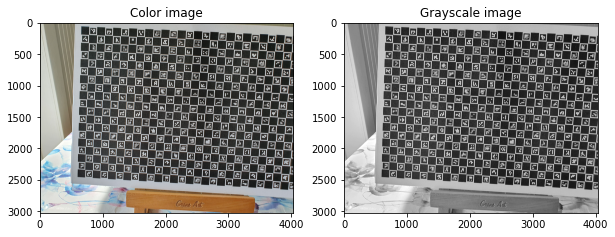

In [9]:
idx = 0

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(cv2.cvtColor(color_images[idx], cv2.COLOR_BGR2RGB))
plt.title("Color image")
plt.subplot(122)
plt.imshow(gayscale_images[idx], cmap="gray")
plt.title("Grayscale image")
plt.show()

The dataset contains 157 charuco borad calibration images

# Parametric camera calibration

# TODO: Tag den med 5 parameter med også

In [10]:
import flexiblecc.Parametric as parcc

To use the charuco board a set of parameters are neede to define the borad's layout. 

- squaresX: The number of squares in the x axis 
- squaresY: The number of squares in the y axis 
- squareLength: The length of a square in meters 
- markerLength: The length of a marker in meters 
- dictionary: dictionary of markers indicating the type of markers. Can normally be found with cv2.aruco.getPredefinedDictionary

In [11]:
squaresX = 28 # [#]
squaresY = 19 # [#]
squareLength = 0.01 # [m]
markerLength = 0.0075 # [m]
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_1000)

In [12]:
calibrate_retval, cameraMatrix, distCoeffs, rvecs, tvecs, stdDeviationsIntrinsics, stdDeviationsExtrinsics, \
    perViewErrors, charucoCorners_all, charucoIds_all, markerCorners_all, armarkerIds_all, obj_points_all, board = parcc.calibrate_camera_charuco(gayscale_images, squaresX, squaresY,
                                                                                                                                                  squareLength, markerLength, dictionary, verbose=1)

  0%|                                                                                                                                                                                                                                         | 0/30 [00:00<?, ?image/s]

Finding charuco features


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.97image/s]


Doing camera calibrate
Calibration done


In [9]:
calibrate_retval, cameraMatrix, distCoeffs, rvecs, tvecs, stdDeviationsIntrinsics, stdDeviationsExtrinsics, perViewErrors, charucoCorners_all, charucoIds_all, markerCorners_all, armarkerIds_all, obj_points_all = np.load("cail.npy", allow_pickle=True)

## First let'sa look at where the charuco borads have been in relation to the camera

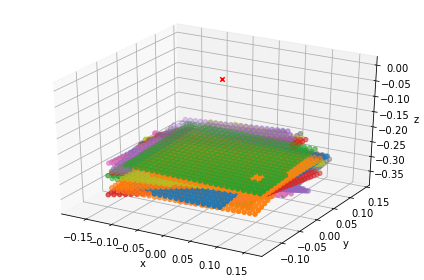

In [13]:
plt.figure()
fcc.Metrics.rtvecs_illustration.draw_rtvecs(rvecs, tvecs, obj_points_all)
plt.tight_layout()
plt.show()

## Let's look at the distorisen the parametric model has deskribet in the camera

First we define a function there kan givein som points return the undistoret points

In [14]:
def undistort(points):
    return cv2.undistortPoints(points, cameraMatrix, distCoeffs, P=cameraMatrix).reshape(-1, 2)

Then we can give the function to plot_distort to create a distorisin plot

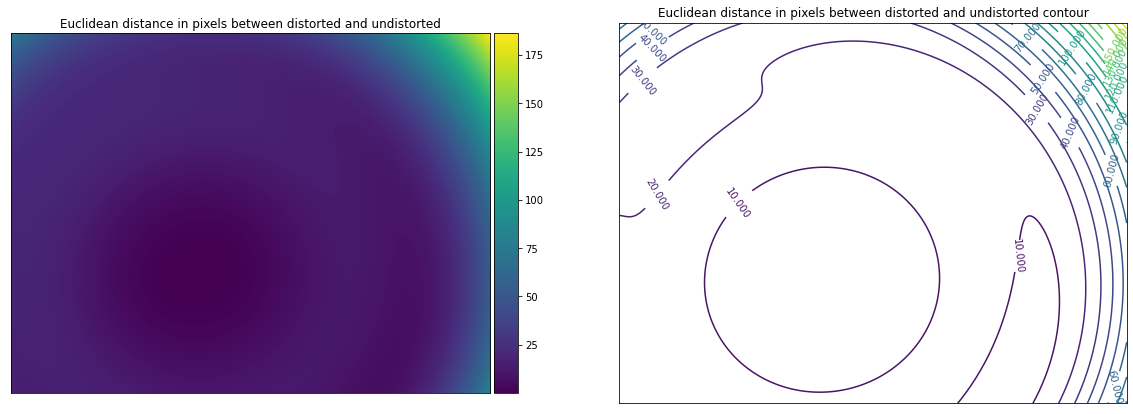

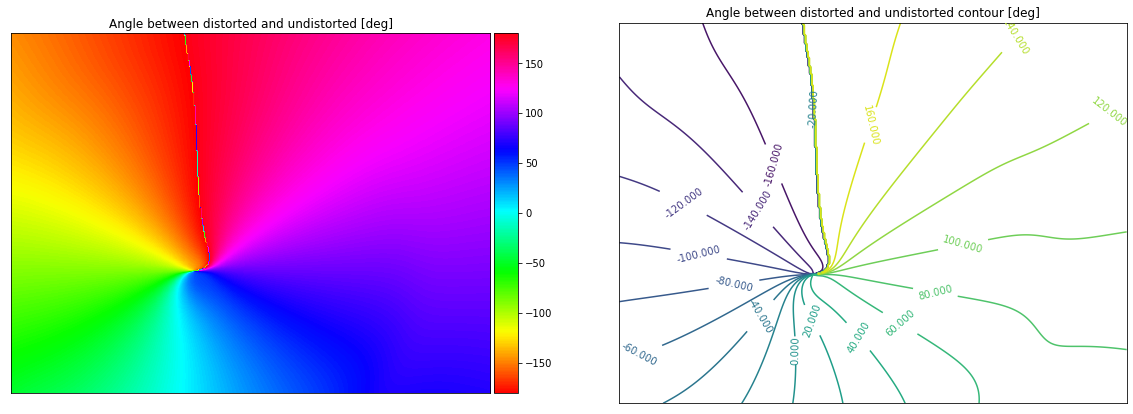

In [15]:
fcc.Metrics.plot_distort(undistort, image_shape, contour_n_levels=20)

## Next we can look for any sytamatic error when reprojectiong the object point to the image plane

This can be done by makeing a voronoi diagram over the angles between the featur points and the correspointing reprojected points

TODO:
- plot også mag

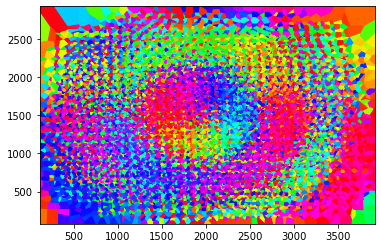

In [16]:
img_points_all, diff_all, angels_all, mag_all = fcc.Metrics.voronoi.projectPoints_and_cal_angles_and_mag(charucoCorners_all, obj_points_all, rvecs, tvecs, cameraMatrix, distCoeffs)
    
plt.figure()
fcc.Metrics.voronoi.plot_voronoi(img_points_all, angels_all)
plt.show()

## Last we can print the RMS reprojection error for the calibrations

In [25]:
print(f"RMS: {calibrate_retval:0.4f} pixels")

RMS: 2.5852 pixels


# Central Model

## Prefit

In [ ]:
Video("test.mp4")

# Bundel adjustmen

In [17]:
from flexiblecc.BundleAdjustment.bundle_adjustment import BundleAdjustment

TODO: 
- insæt diagrammet med hvordan man finder resuidals som svg (bare brug HTML fra github folder så den kan findes på servere osv)
- Sparsity og hvordan den udregnes

In [45]:
ba = BundleAdjustment(obj_points_all, rvecs, tvecs, charucoCorners_all, cameraMatrix, distCoeffs, image_shape[::-1], cm_stepsize=1000, cm_order=4, ls_ftol=1, ls_gtol=1)

Starting least squares fitting of CentralModel.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.9397e-02                                    6.40e-02    
       1              2         2.6279e-17      4.94e-02       6.48e-01       1.46e-09    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 4.9397e-02, final cost 2.6279e-17, first-order optimality 1.46e-09.


TODO
- plot sparsity

In [46]:
cm, res, rvecs_new, tvecs_new = ba.least_squares()

Generating sparsity matrix
Performing least squares optimization on the control points and position of the chessboards
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.1732e+04                                    5.46e+09    
       1              3         2.1732e+04      0.00e+00       0.00e+00       5.46e+09    
`xtol` termination condition is satisfied.
Function evaluations 3, initial cost 2.1732e+04, final cost 2.1732e+04, first-order optimality 5.46e+09.


# After bundel adjustmen

### Voronoi

In [ ]:
residuals_2D, estimated_points_2D, correct_points_2D = ba.calc_residuals_2D(res.x, return_points_2D=True)

In [ ]:
image_points = np.concatenate(correct_points_2D)
project_points = np.concatenate(estimated_points_2D)
imp, diff, angels, mag = fcc.Metrics.voronoi.cal_angles_and_mag(image_points, project_points)

In [ ]:
plt.figure()
fcc.Metrics.voronoi.plot_voronoi(imp, angels)
plt.show()

# Samlinginig (TODO engelsk)

TODO:
- Lav stort plot med 5, 14, CM
- Lav table over RMS's 
værdiger